# Import Necessary Library

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers , models

# Loading the data

In [144]:
(X_train , _) , (X_test , _) = cifar10.load_data()

# Visualizing the Original Images

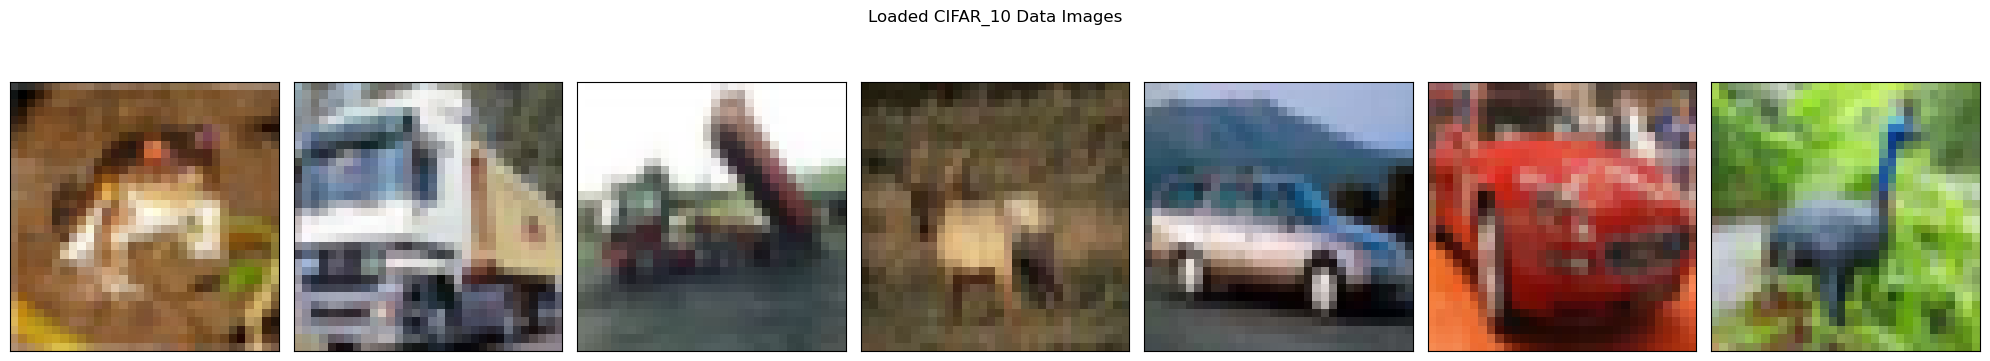

In [146]:
n = 7
plt.figure(figsize=(20,4)) 
for i in range(n):
  ax = plt.subplot(1, n , i+1)
  plt.imshow(X_train[i].reshape(32,32,3)) 
  plt.gray()
  ax.get_xaxis().set_visible(False) #do not want any x ticks
  ax.get_yaxis().set_visible(False) 

plt.suptitle("Loaded CIFAR_10 Data Images")
plt.tight_layout()
plt.show()

# Normalizing the data

In [148]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Converting RGB Images into GrayScale

In [150]:
def rgb_to_grays(images):
    # Apply the formula to each pixel
    grayscale = np.dot(images[...,:3],[0.299, 0.587, 0.114]) # all 3 color channels for each pixel with weights for RGB 
    # Expand the dimensions (adds a new dimension at the end)
    return np.expand_dims(grayscale , axis = -1) # from (32,32) to (32,32,1)

In [151]:
# Applying to train and test set
X_train_grayimg = rgb_to_grays(X_train)
X_test_grayimg = rgb_to_grays(X_test)

In [152]:
X_train_grayimg.shape

(50000, 32, 32, 1)

### Visualizing the Original and Black & White Image

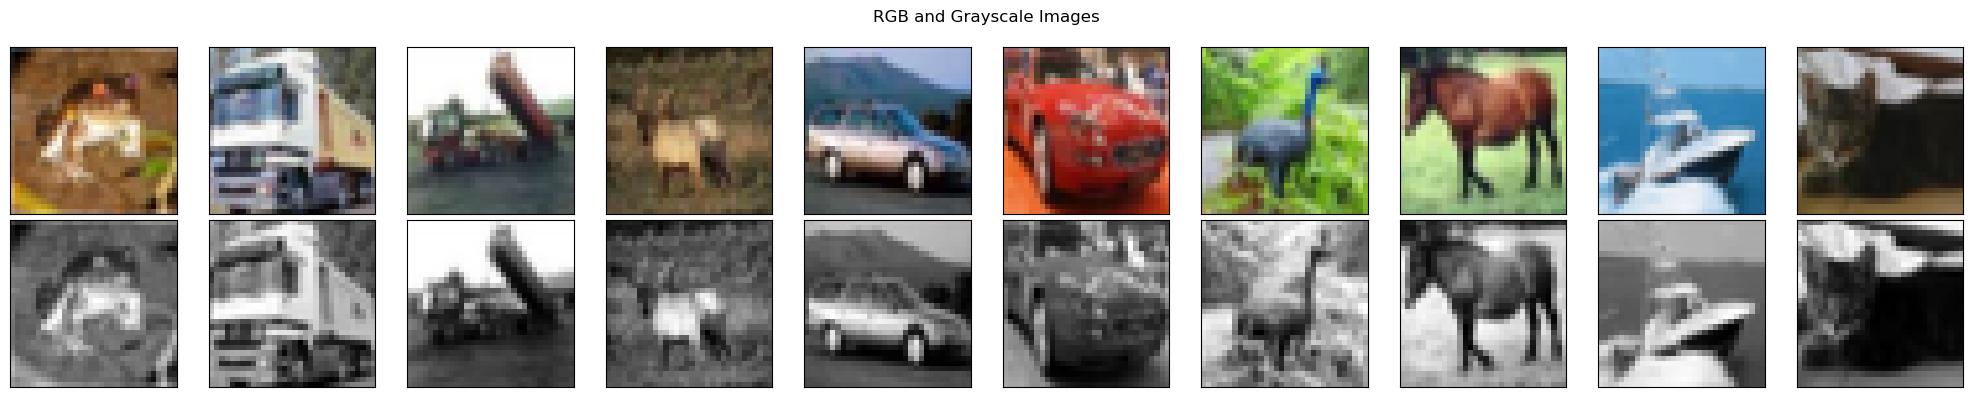

In [154]:
n = 10
plt.figure(figsize=(20,4))

for i in range(n):
  #original image
  ax = plt.subplot(2, n , i+1)
  plt.imshow(X_train[i].reshape(32,32,3))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  #GrayScale image
  ax = plt.subplot(2, n , i+1+n)
  plt.imshow(X_train_grayimg[i].reshape(32,32,1))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.suptitle("RGB and Grayscale Images")
plt.tight_layout()
plt.show()

## Flatten for Dense Layer

In [156]:
# From 32*32*1 to (1024,)
X_train_flat = X_train_grayimg.reshape(len(X_train_grayimg) , -1)
X_test_flat = X_test_grayimg.reshape(len(X_test_grayimg) , -1)

# Building the Dense AutoEncoder Model

In [167]:
# Inputs
input_dims = 32 * 32 

# Bottleneck Sizes
bottle_neck_Size = 64
results = {}


def build_autoencoder(input_dims,bottle_neck_Size):
    input_img = layers.Input(shape=(input_dims,))
# Encoder
    encoded = layers.Dense(512 , activation = 'relu')(input_img)
    encoded = layers.Dense(128 , activation = 'relu')(encoded)
    encoded_f = layers.Dense(bottle_neck_Size , activation = 'relu')(encoded) # bottleneck

# Decoder
    decoded = layers.Dense(128 , activation = 'relu')(encoded_f)
    decoded = layers.Dense(512 , activation = 'relu')(decoded)
    decoded_f = layers.Dense(input_dims , activation = 'sigmoid')(decoded)

# Autoencoder
    autoencoder = models.Model(inputs = input_img , outputs = decoded_f)
    autoencoder.compile( optimizer = 'adam' , loss = 'mse')
    return autoencoder

In [169]:
# Inputs
input_dims = 32 * 32 

# Bottleneck Sizes
encoding_dims_list = [32, 64, 128, 512]
results = {}

def build_autoencoder(input_dims,bottle_neck_Size):
    input_img = layers.Input(shape=(input_dims,))
# Encoder
    encoded = layers.Dense(512 , activation = 'relu')(input_img)
    encoded = layers.Dense(128 , activation = 'relu')(encoded)
    encoded_f = layers.Dense(bottle_neck_Size , activation = 'relu')(encoded) # bottleneck

# Decoder
    decoded = layers.Dense(128 , activation = 'relu')(encoded_f)
    decoded = layers.Dense(512 , activation = 'relu')(decoded)
    decoded_f = layers.Dense(input_dims , activation = 'sigmoid')(decoded)

# Autoencoder
    autoencoder = models.Model(inputs = input_img , outputs = decoded_f)
    autoencoder.compile( optimizer = 'adam' , loss = 'mse')
    return autoencoder

In [171]:
for bottle_neck_Size  in encoding_dims_list:
    print(f"\nTraining for bottleneck size {bottle_neck_Size}")
autoencoder = build_autoencoder(input_dims,bottle_neck_Size )


Training for bottleneck size 32

Training for bottleneck size 64

Training for bottleneck size 128

Training for bottleneck size 512


# Train the Model

In [173]:
history = autoencoder.fit(X_train_flat ,
                X_train_flat ,
                epochs = 5 ,
                batch_size = 256,
                shuffle = True ,
                validation_data = (X_test_flat , X_test_flat)
               )

Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - loss: 0.0419 - val_loss: 0.0209
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0205 - val_loss: 0.0178
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.0172 - val_loss: 0.0153
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.0149 - val_loss: 0.0143
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0137 - val_loss: 0.0129


In [175]:
results[bottle_neck_size] = {
        "model": autoencoder,
        "history": history
    }

In [177]:
results

{32: {'model': <Functional name=functional_2, built=True>,
  'history': <keras.src.callbacks.history.History at 0x1a69a9e9760>}}

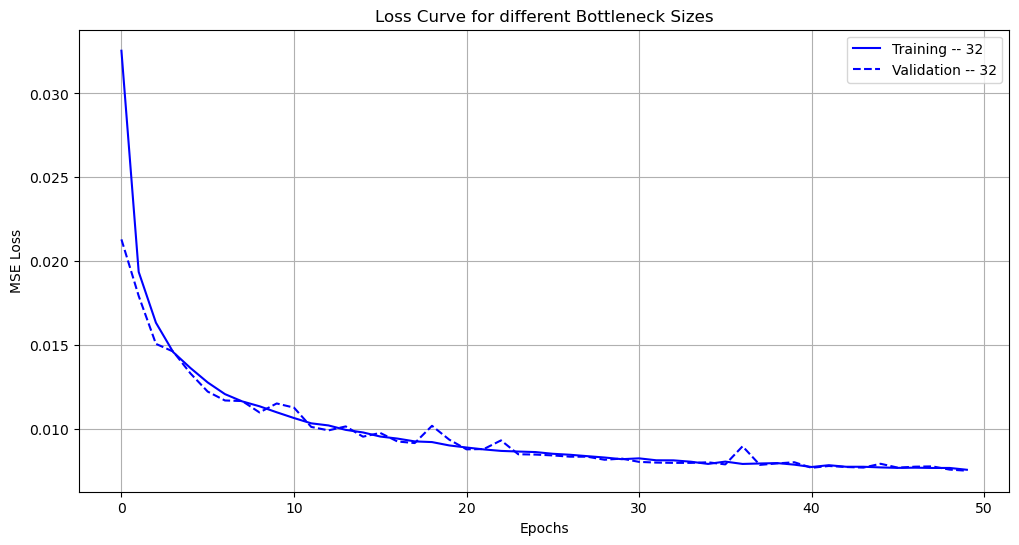

In [129]:
 # Plot loss curve
colors = ['b' , 'g' , 'r' , 'c', 'm' , 'y' , 'k' ]
plt.figure(figsize=(12,6))
for idx , bottle_neck_size in enumerate(results.keys()):
    history = results[bottle_neck_size]['history']
    color = colors[idx % len(colors)]
    plt.plot(history.history['loss'], color = color , linestyle = '-' ,label= f'Training -- {bottle_neck_size}')
    plt.plot(history.history['val_loss'],color = color , linestyle = '--', label= f'Validation -- {bottle_neck_size}')
plt.title(f'Loss Curve for different Bottleneck Sizes')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show() 

In [131]:
# Reconstructed version of the test data.
decoded_img = autoencoder.predict(X_test_flat)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [133]:
# Reshape back to 32 * 32
X_test_imgs = X_test_flat.reshape((-1,32,32))
decoded_img_reshaped = decoded_img.reshape((-1,32,32))

# Visualizing the Results

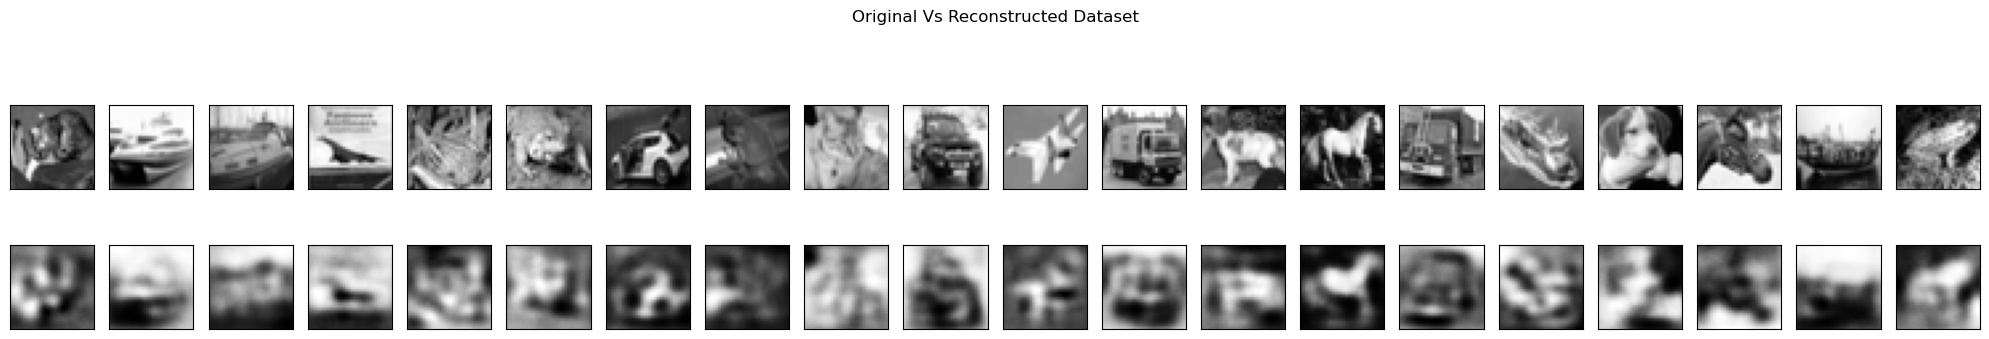

In [137]:
n = 20
plt.figure(figsize=(20,4))

for i in range(n):
  #Original image
  ax = plt.subplot(2, n , i+1)
  plt.imshow(X_test_imgs[i])
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  #Reconstructed image
  ax = plt.subplot(2, n , i+1+n)
  plt.imshow(decoded_img_reshaped[i])
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.suptitle("Original Vs Reconstructed Dataset")
plt.tight_layout()
plt.show()